# Jupyter for working with cars dataset

In [1]:
import csv
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Describe and analyze data

Data was prepared beforehand. That means, that original `.csv` file differs from that, what we use here.

In [2]:
data = pd.read_csv("car_price_prediction.csv")

In [3]:
data.head()

,Price,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Turbo
0,13328,LEXUS,RX 450,2010,Jeep,True,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,False
1,16621,CHEVROLET,Equinox,2011,Jeep,False,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,False
2,8467,HONDA,FIT,2006,Hatchback,False,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,False
3,3607,FORD,Escape,2011,Jeep,True,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,False
4,11726,HONDA,FIT,2014,Hatchback,True,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Manufacturer      19237 non-null  object 
 2   Model             19237 non-null  object 
 3   Prod. year        19237 non-null  int64  
 4   Category          19237 non-null  object 
 5   Leather interior  19237 non-null  bool   
 6   Fuel type         19237 non-null  object 
 7   Engine volume     19237 non-null  float64
 8   Mileage           19237 non-null  int64  
 9   Cylinders         19237 non-null  float64
 10  Gear box type     19237 non-null  object 
 11  Drive wheels      19237 non-null  object 
 12  Doors             19237 non-null  int64  
 13  Wheel             19237 non-null  object 
 14  Color             19237 non-null  object 
 15  Turbo             19237 non-null  bool   
dtypes: bool(2), float64(2), int64(4), object

In [5]:
data.describe()

,Price,Prod. year,Engine volume,Mileage,Cylinders,Doors
count,1.923700e+04,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000
mean,1.855593e+04,2010.912824,2.307990,1.532236e+06,4.582991,3.925872
std,1.905813e+05,5.668673,0.877805,4.840387e+07,1.199933,0.403399
min,1.000000e+00,1939.000000,0.000000,0.000000e+00,1.000000,2.000000
25%,5.331000e+03,2009.000000,1.800000,7.013900e+04,4.000000,4.000000
50%,1.317200e+04,2012.000000,2.000000,1.260000e+05,4.000000,4.000000
75%,2.207500e+04,2015.000000,2.500000,1.888880e+05,4.000000,4.000000
max,2.630750e+07,2020.000000,20.000000,2.147484e+09,16.000000,5.000000


In [6]:
data.shape

(19237, 16)

Finding unique values in each column

In [7]:
for col in data.columns:
    print(col)
    print(data[f'{col}'].unique())
    print('*'*75)

Price
[13328 16621  8467 ... 56814 63886 22075]
***************************************************************************
Manufacturer
['LEXUS' 'CHEVROLET' 'HONDA' 'FORD' 'HYUNDAI' 'TOYOTA' 'MERCEDES-BENZ'
 'OPEL' 'PORSCHE' 'BMW' 'JEEP' 'VOLKSWAGEN' 'AUDI' 'RENAULT' 'NISSAN'
 'SUBARU' 'DAEWOO' 'KIA' 'MITSUBISHI' 'SSANGYONG' 'MAZDA' 'GMC' 'FIAT'
 'INFINITI' 'ALFA ROMEO' 'SUZUKI' 'ACURA' 'LINCOLN' 'VAZ' 'GAZ' 'CITROEN'
 'LAND ROVER' 'MINI' 'DODGE' 'CHRYSLER' 'JAGUAR' 'ISUZU' 'SKODA'
 'DAIHATSU' 'BUICK' 'TESLA' 'CADILLAC' 'PEUGEOT' 'BENTLEY' 'VOLVO' 'სხვა'
 'HAVAL' 'HUMMER' 'SCION' 'UAZ' 'MERCURY' 'ZAZ' 'ROVER' 'SEAT' 'LANCIA'
 'MOSKVICH' 'MASERATI' 'FERRARI' 'SAAB' 'LAMBORGHINI' 'ROLLS-ROYCE'
 'PONTIAC' 'SATURN' 'ASTON MARTIN' 'GREATWALL']
***************************************************************************
Model
['RX 450' 'Equinox' 'FIT' ... 'E 230 124' 'RX 450 F SPORT' 'Prius C aqua']
***************************************************************************
Prod. year
[2010 

## Inspection for outliers

We have to check if data contains some values, that are laying too far from normal and thus can influence our future model

Criteria: any data point whose Z-score falls out of 3rd standard deviation is an outlier.

![](doc/z-score.png)

Data points that lie 1.5 times of IQR above Q3 and below Q1 are outliers. This shows in detail about outlier treatment in Python.

![](doc/iqr.png)

Steps
- Sort the dataset in ascending order
- calculate the 1st and 3rd quartiles(Q1, Q3)
- compute $IQR=Q3-Q1$
- compute $lower\_bound = (Q1–1.5\cdot IQR)$, $upper\_bound = (Q3+1.5\cdot IQR)$
- loop through the values of the dataset and check for those who fall below the lower bound and above the upper bound and mark them as outliers

To utilize this, function `detect_outliers` was created. It returns indices, that are too much of a difference with all values.

We mainly have to deal with `Price` and `Mileage`, as they are only "numeric" values

In [8]:
def detect_outliers(dataframe, columns, threshold=1.5):
    outlier_indices = []

    for c in columns:
        Q1 = np.percentile(dataframe[c], 25)
        Q3 = np.percentile(dataframe[c], 75)
        IQR = Q3 - Q1
        outlier_step = IQR * threshold
        outlier_list_col = dataframe[(dataframe[c] < Q1 - outlier_step)
                                     | (dataframe[c] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    return outlier_indices

columns_to_detect = ["Mileage", "Price"]

outliers = detect_outliers(data, columns_to_detect)
print(outliers)

[8, 29, 39, 65, 90, 144, 169, 191, 252, 281, 351, 369, 400, 428, 429, 475, 493, 508, 513, 517, 563, 598, 625, 640, 712, 731, 748, 824, 850, 868, 918, 943, 964, 966, 985, 1042, 1053, 1086, 1093, 1118, 1128, 1146, 1148, 1156, 1170, 1208, 1254, 1337, 1368, 1373, 1386, 1404, 1410, 1544, 1560, 1622, 1665, 1701, 1710, 1765, 1788, 1806, 1821, 1846, 1881, 1892, 1893, 1912, 1920, 1950, 2033, 2075, 2105, 2118, 2123, 2126, 2127, 2138, 2188, 2255, 2274, 2278, 2286, 2319, 2324, 2399, 2418, 2461, 2464, 2501, 2512, 2529, 2584, 2588, 2635, 2638, 2666, 2874, 2897, 2903, 2952, 2961, 2986, 3043, 3056, 3083, 3097, 3170, 3177, 3219, 3282, 3320, 3326, 3505, 3548, 3604, 3607, 3624, 3627, 3652, 3698, 3706, 3715, 3721, 3726, 3744, 3747, 3781, 3792, 3845, 3850, 3877, 3895, 3896, 3985, 3995, 4004, 4009, 4023, 4040, 4061, 4079, 4080, 4130, 4148, 4170, 4174, 4175, 4187, 4200, 4230, 4248, 4371, 4394, 4429, 4432, 4445, 4516, 4541, 4552, 4658, 4685, 4694, 4823, 4892, 4893, 4907, 4941, 4996, 5068, 5130, 5146, 5164, 52

Let's now check how values are placed in our array

In [9]:
def print_ranges(c, threshold=1.5):
    Q1 = np.percentile(data[c], 25)
    Q3 = np.percentile(data[c], 75)
    IQR = Q3 - Q1
    outlier_step = IQR * threshold
    left = Q1 - outlier_step
    right = Q3 + outlier_step
    print(f"Ranges for {c}: {left}: {right}")
    
print_ranges("Mileage")
print_ranges("Price")
data.iloc[29]

Ranges for Mileage: -107984.5: 367011.5
Ranges for Price: -19785.0: 47191.0


Price                    12074
Manufacturer            TOYOTA
Model               Highlander
Prod. year                2009
Category                  Jeep
Leather interior          True
Fuel type               Hybrid
Engine volume              3.3
Mileage                 420550
Cylinders                  6.0
Gear box type        Automatic
Drive wheels               4x4
Doors                        4
Wheel               Left wheel
Color                     Blue
Turbo                    False
Name: 29, dtype: object

As we can see, this line has too high `Mileage`, thus is an outlier. You will see in the next cells why data has to be cleaned

In [10]:
cleaned_data = data.drop(data.loc[outliers].index,axis=0)

## Plotting data

### Clean data

This is how cleaned data is plotted

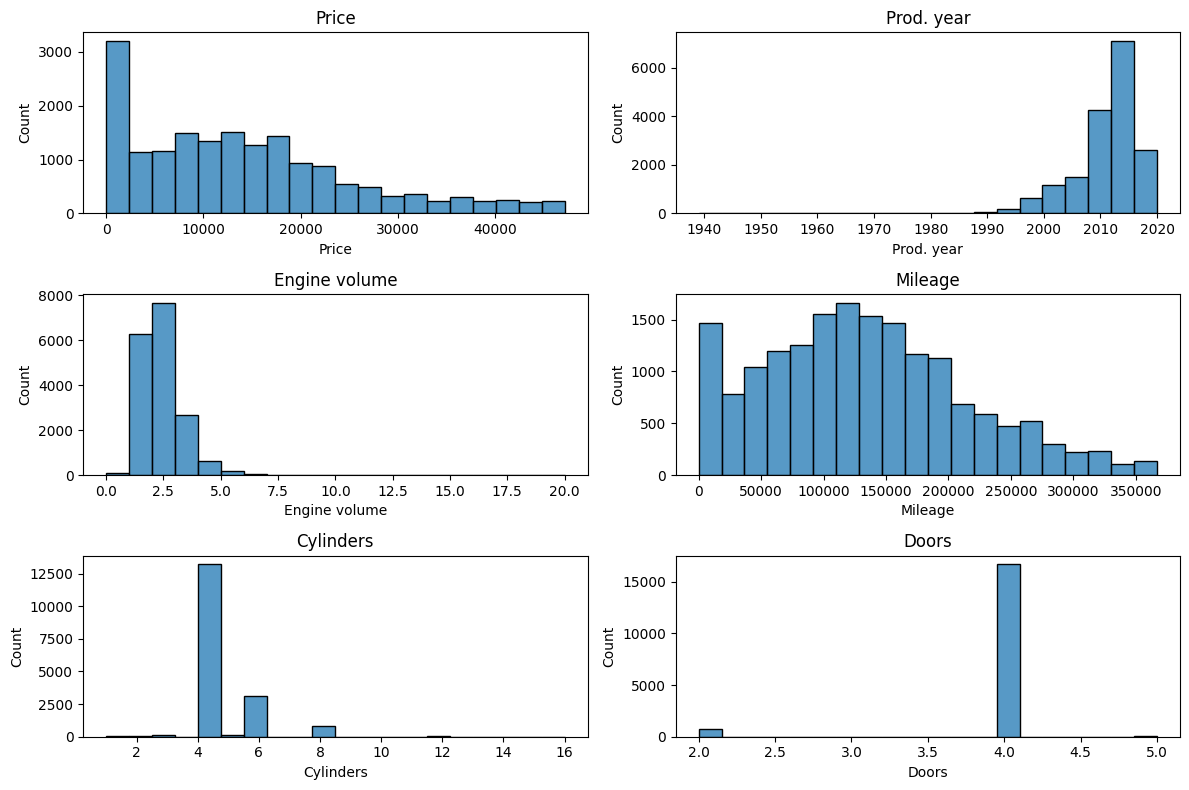

In [11]:
numerical_columns = ['Price', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Doors']

plt.figure(figsize=(12, 8))
for feature in numerical_columns:
    plt.subplot(3, 2, numerical_columns.index(feature) + 1)
    sns.histplot(data=cleaned_data[feature], bins=20)
    plt.title(feature)
plt.tight_layout()
plt.show()



### Unprepared data

This is what original data looks like (with a lot of outliers)

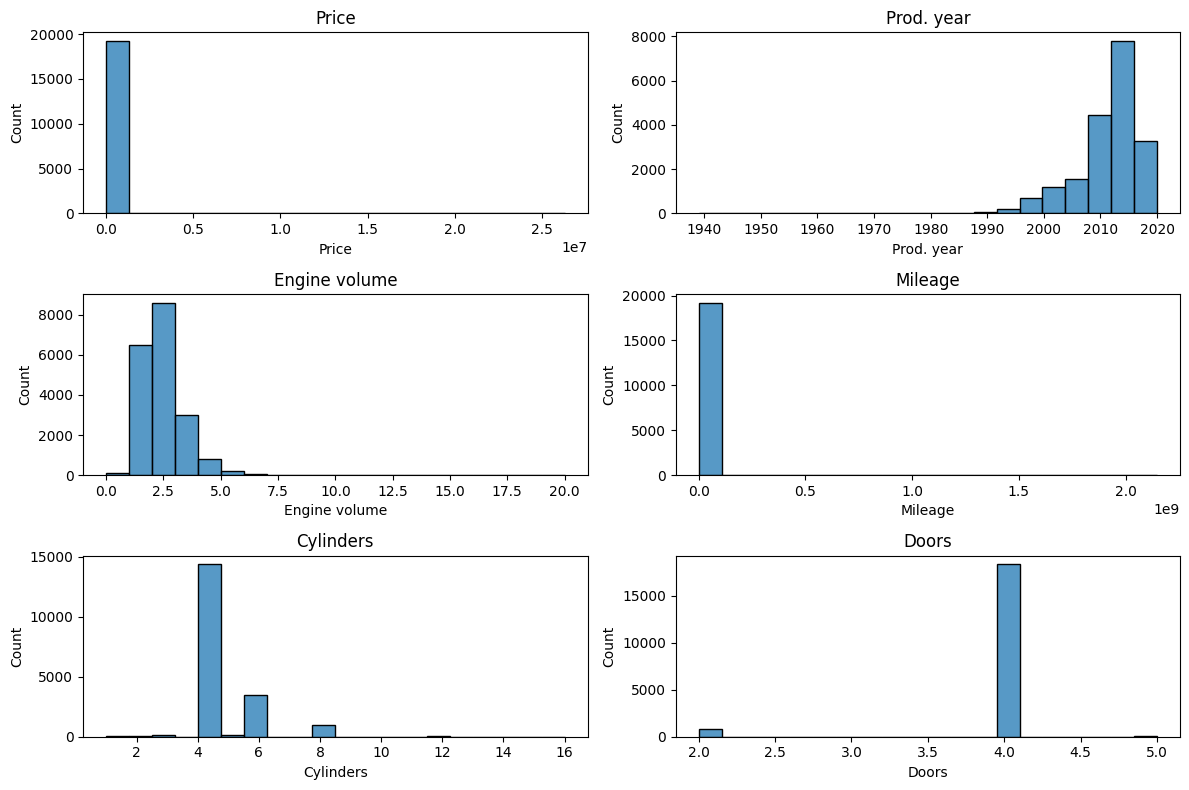

In [12]:
plt.figure(figsize=(12, 8))
for feature in numerical_columns:
    plt.subplot(3, 2, numerical_columns.index(feature) + 1)
    sns.histplot(data=data[feature], bins=20)
    plt.title(feature)
plt.tight_layout()
plt.show()

### How data is split among categories

Let's plot cathegorical columns

In [13]:
cleaned_data.columns

Index(['Price', 'Manufacturer', 'Model', 'Prod. year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Turbo'],
      dtype='object')

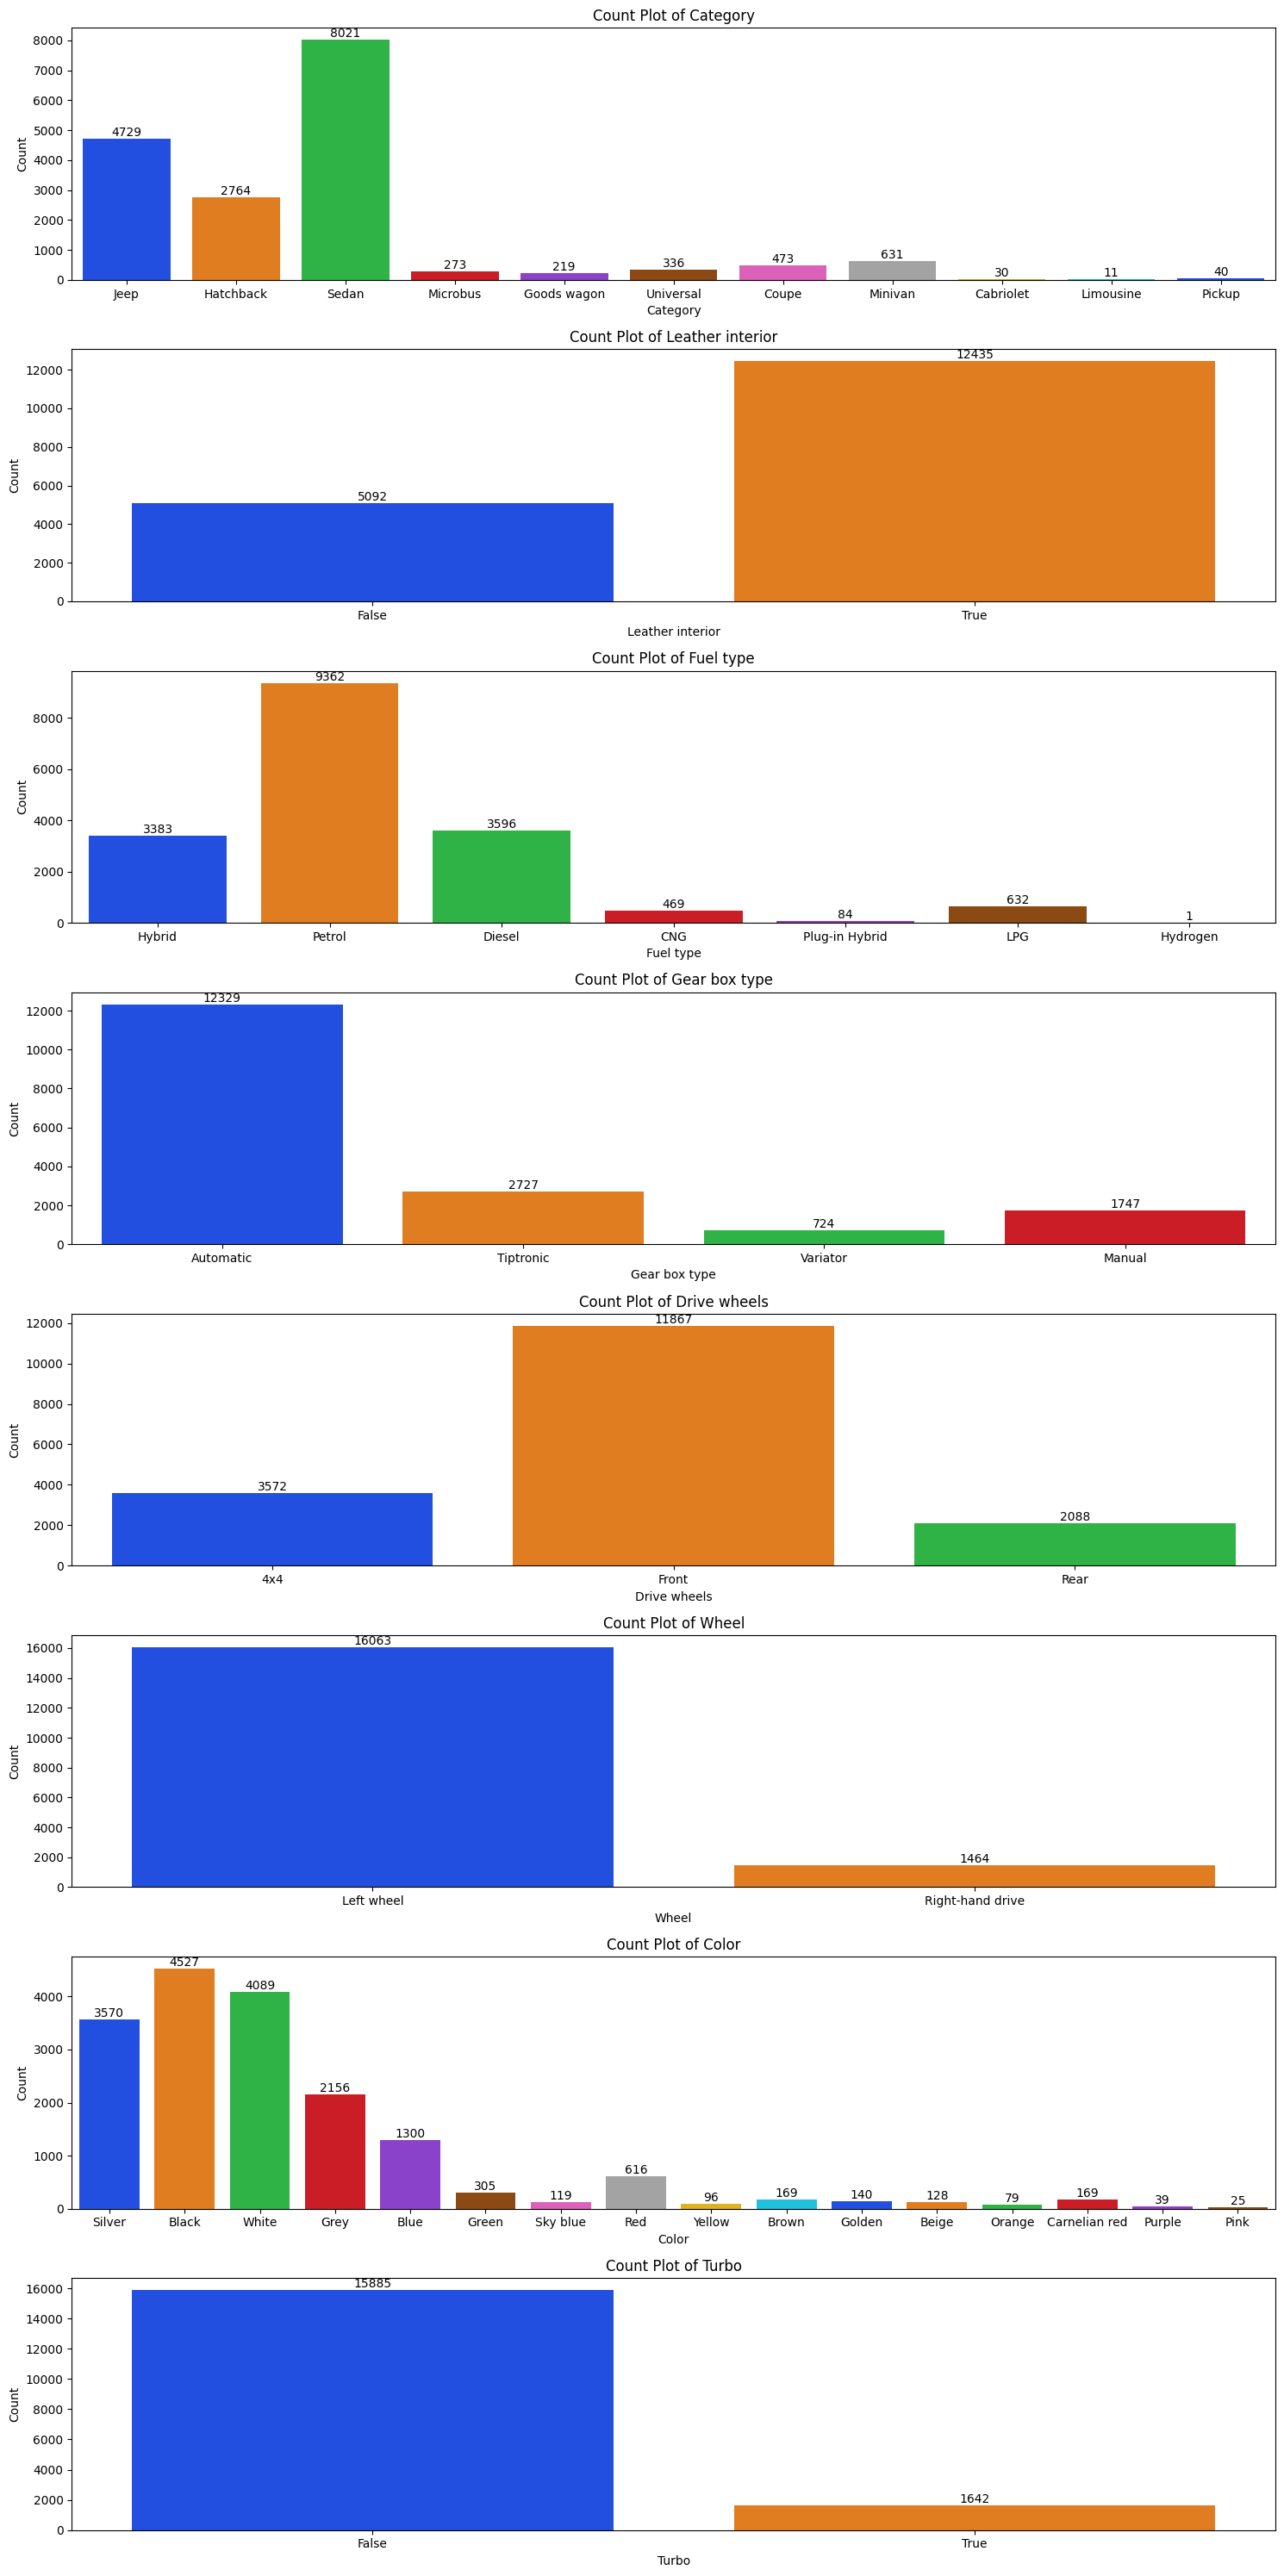

In [14]:
categorical_columns = ['Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color', 'Turbo']

fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(15, 30))
axes = axes.ravel()  # Flatten the 2D array of axes

# Loop through each categorical column
for i, column in enumerate(categorical_columns):
    sns.countplot(x=cleaned_data[column], data=cleaned_data, legend=False, ax=axes[i], palette="bright", hue=cleaned_data[column])
    for container in axes[i].containers:
        axes[i].bar_label(container, color='black', size=10)
    axes[i].set_title(f'Count Plot of {column.capitalize()}')
    axes[i].set_xlabel(column.capitalize())
    axes[i].set_ylabel('Count')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


We can also see which cars are sold the most

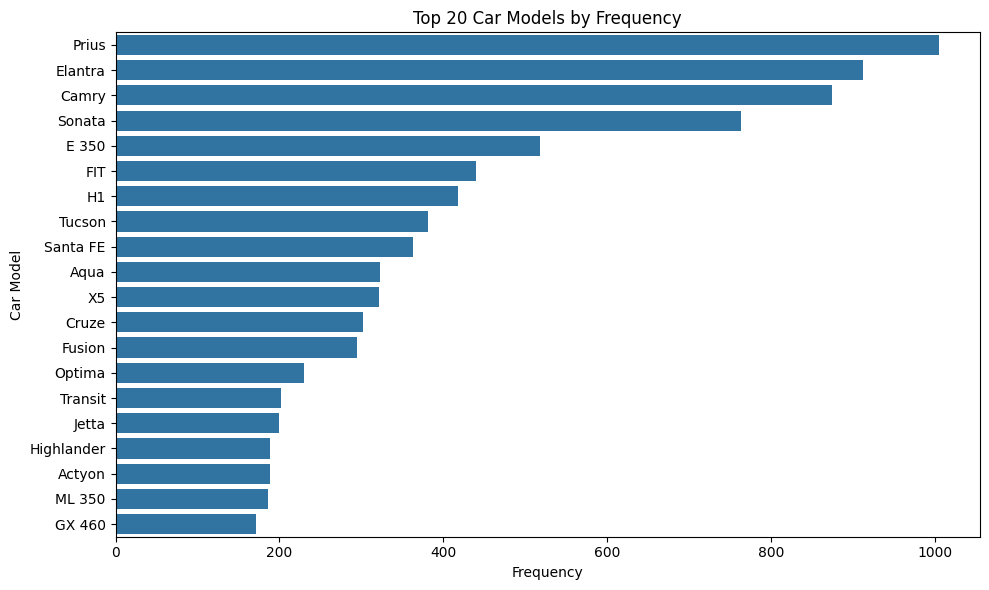

In [15]:
n = 20  # Number of top car models to plot
top_car_models = cleaned_data['Model'].value_counts().head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index)
plt.title(f'Top {n} Car Models by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Car Model')
plt.tight_layout()
plt.show()

### Feature vs Price

In this chapter we will try to find most influencial cathegory on price.

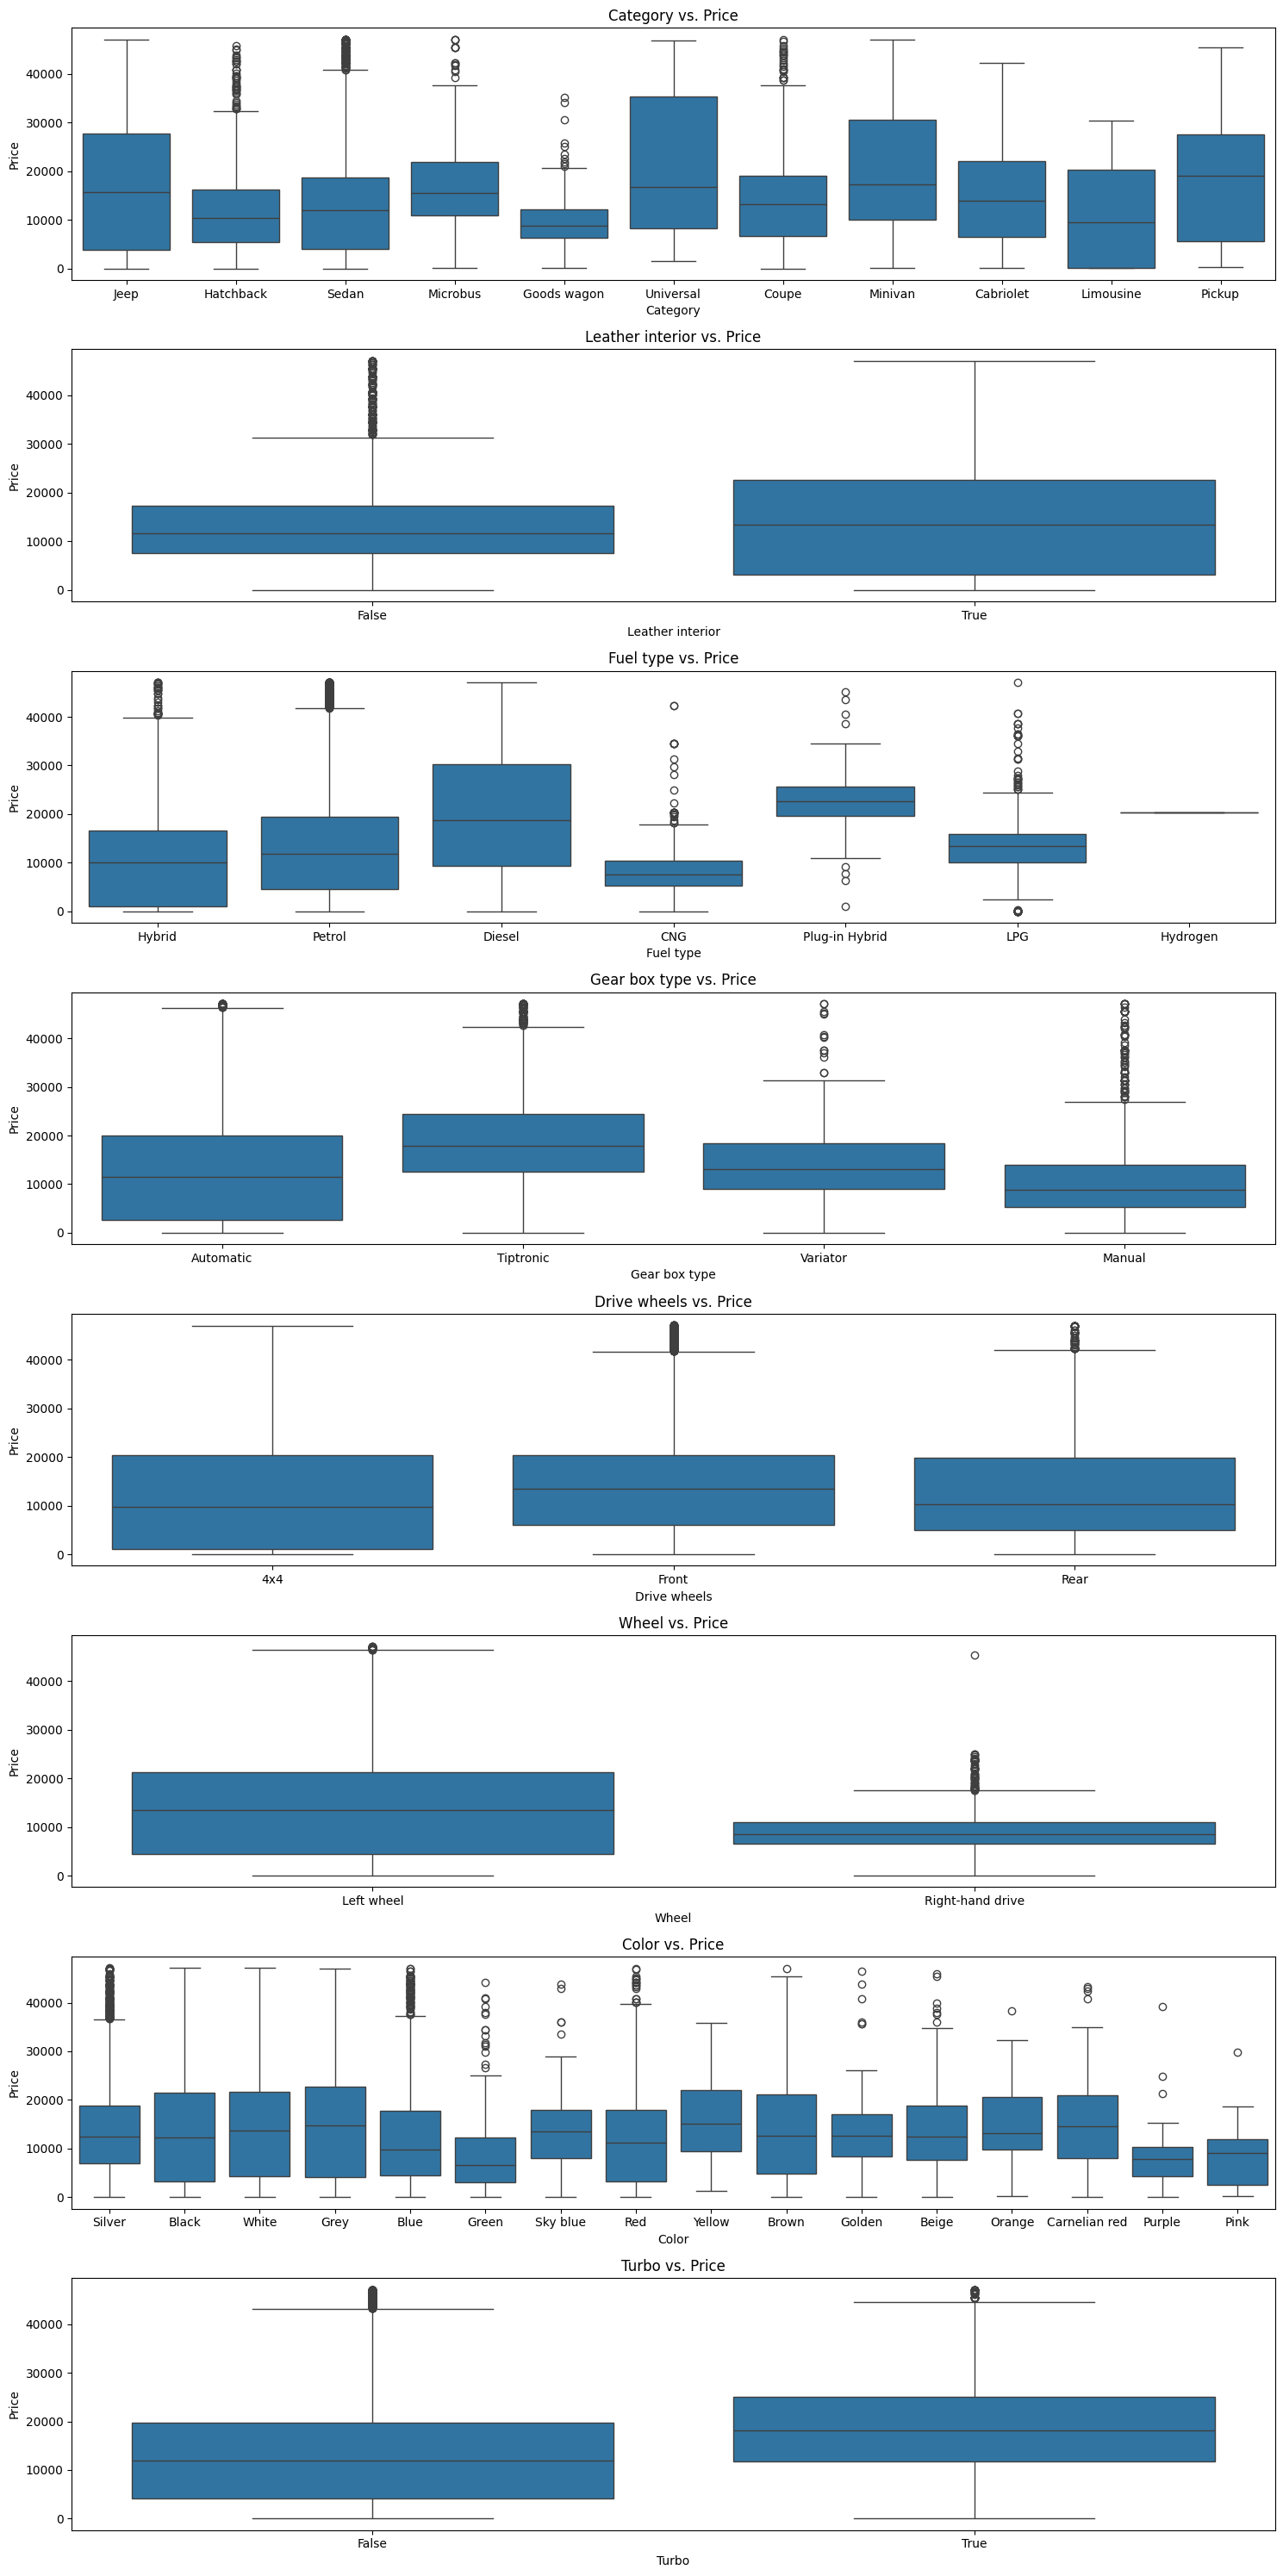

In [16]:
plt.figure(figsize=(15, 30))
for feature in categorical_columns:
    plt.subplot(8, 1, categorical_columns.index(feature) + 1)
    sns.boxplot(data=cleaned_data, x=feature, y='Price')
    plt.title(f'{feature} vs. Price')
plt.tight_layout()
plt.show()

### Correlation analysis

Lastly, let's focus on doing the correlation heatmap

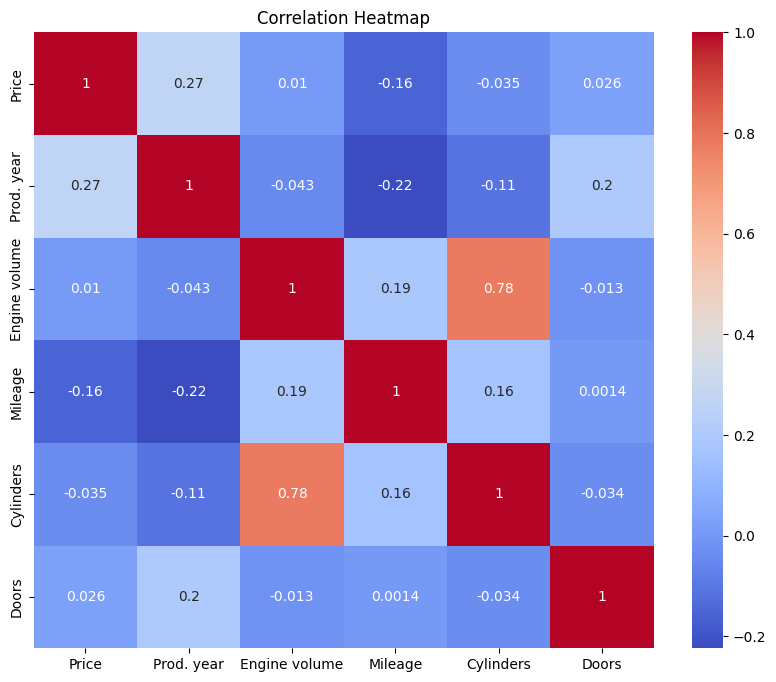

In [17]:
correlation_matrix = cleaned_data[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Train and work with models

In [18]:
detect_outliers(cleaned_data, ["Price"])
cleaned_data.loc[41]

Price                    45734
Manufacturer           HYUNDAI
Model                       H1
Prod. year                2016
Category             Universal
Leather interior          True
Fuel type               Diesel
Engine volume              2.5
Mileage                  61057
Cylinders                  4.0
Gear box type        Automatic
Drive wheels             Front
Doors                        4
Wheel               Left wheel
Color                    Black
Turbo                    False
Name: 41, dtype: object

In [19]:
# dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# label_encoder.classes_

In [20]:
cleaned_data

,Price,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Turbo
0,13328,LEXUS,RX 450,2010,Jeep,True,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,False
1,16621,CHEVROLET,Equinox,2011,Jeep,False,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,False
2,8467,HONDA,FIT,2006,Hatchback,False,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,False
3,3607,FORD,Escape,2011,Jeep,True,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,False
4,11726,HONDA,FIT,2014,Hatchback,True,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,MERCEDES-BENZ,CLK 200,1999,Coupe,True,CNG,2.0,300000,4.0,Manual,Rear,2,Left wheel,Silver,True
19233,15681,HYUNDAI,Sonata,2011,Sedan,True,Petrol,2.4,161600,4.0,Tiptronic,Front,4,Left wheel,Red,False
19234,26108,HYUNDAI,Tucson,2010,Jeep,True,Diesel,2.0,116365,4.0,Automatic,Front,4,Left wheel,Grey,False
19235,5331,CHEVROLET,Captiva,2007,Jeep,True,Diesel,2.0,51258,4.0,Automatic,Front,4,Left wheel,Black,False


In [42]:
cleaned_data = cleaned_data.dropna()
cleaned_data

,Price,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Turbo
0,13328,LEXUS,RX 450,2010,Jeep,True,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,False
1,16621,CHEVROLET,Equinox,2011,Jeep,False,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,False
2,8467,HONDA,FIT,2006,Hatchback,False,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,False
3,3607,FORD,Escape,2011,Jeep,True,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,False
4,11726,HONDA,FIT,2014,Hatchback,True,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,MERCEDES-BENZ,CLK 200,1999,Coupe,True,CNG,2.0,300000,4.0,Manual,Rear,2,Left wheel,Silver,True
19233,15681,HYUNDAI,Sonata,2011,Sedan,True,Petrol,2.4,161600,4.0,Tiptronic,Front,4,Left wheel,Red,False
19234,26108,HYUNDAI,Tucson,2010,Jeep,True,Diesel,2.0,116365,4.0,Automatic,Front,4,Left wheel,Grey,False
19235,5331,CHEVROLET,Captiva,2007,Jeep,True,Diesel,2.0,51258,4.0,Automatic,Front,4,Left wheel,Black,False


In [48]:
label_encoder = LabelEncoder()
# data['Engine volume_new'] = label_encoder.fit_transform(data['Engine volume'])
# dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

train_frame = pd.DataFrame()

transform_dict = {"Manufacturer" : {},
                  "Category" : {},
                  "Leather interior" : {},
                  "Fuel type" : {},
                  "Engine volume" : {},
                  "Gear box type" : {},
                  "Drive wheels" : {},
                  "Wheel" : {},
                  "Turbo" : {}}

for key in transform_dict:
    label_encoder = LabelEncoder()
    train_frame[key] = label_encoder.fit_transform(cleaned_data[key])
    transform_dict[key] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    
for column in data.columns:
    if column not in train_frame.columns and column != "Model" and column != "Color":
        train_frame[column] = cleaned_data[column]

In [49]:
len(train_frame)

17527

In [50]:
scaler = StandardScaler()
# scaler.fit(train_frame.drop(['Color'], axis=1))
# final_data = scaler.transform(train_frame.drop(['Color'], axis=1))
num_data = scaler.fit_transform(train_frame.drop(['Price'], axis=1))

num_data

array([[-0.10077186, -0.81555925,  0.63991354, ...,  0.65780054,
         1.24292281,  0.1864834 ],
       [-1.39682691, -0.81555925, -1.5627111 , ...,  0.73159798,
         1.24292281,  0.1864834 ],
       [-0.68988779, -1.17300629, -1.5627111 , ...,  0.83007663,
        -0.47517182,  0.1864834 ],
       ...,
       [-0.57206461, -0.81555925,  0.63991354, ...,  1.07125085,
        -0.47517182,  0.1864834 ],
       [-1.39682691, -0.81555925,  0.63991354, ..., -1.6166993 ,
        -0.47517182, -4.73365525],
       [-0.57206461,  0.97167593,  0.63991354, ...,  0.70333461,
         2.96101744,  0.1864834 ]])

In [52]:
train_data = pd.DataFrame(num_data, columns = ['Manufacturer', 'Prod. year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel',
       'Turbo'])
X_train, X_test, y_train, y_test = train_test_split(train_data, train_frame['Price'], test_size=0.2, random_state = 123)
print(X_train.isna().sum())
# lin_reg = LinearRegression()

# lin_reg.fit(X_train, y_train)
# y_pred = lin_reg.predict(X_train)
# lin_mse = mean_squared_error(y_train, y_pred)
# lin_rmse = np.sqrt(lin_mse)
# lin_rmse

Manufacturer           0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Engine volume          0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels        1270
Doors               1270
Wheel               1270
Turbo               1270
dtype: int64


In [26]:
mae = mean_absolute_error(y_train, y_pred)
mae

NameError: name 'y_train' is not defined

In [ ]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df